In [20]:
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_X_y
import numpy as np
import random
import seaborn as sns; sns.set()

In [1]:
def discr_stat(
    X, Y, dissimilarity="euclidean", remove_isolates=True, return_rdfs=False
):
    """
    Computes the discriminability statistic.
    Parameters
    ----------
    X : array, shape (n_samples, n_features) or (n_samples, n_samples)
        Input data. If dissimilarity=='precomputed', the input should be the dissimilarity matrix.
    Y : 1d-array, shape (n_samples)
        Input labels.
    dissimilarity : str, {"euclidean" (default), "precomputed"}
        Dissimilarity measure to use:
        - 'euclidean':
            Pairwise Euclidean distances between points in the dataset.
        - 'precomputed':
            Pre-computed dissimilarities.
    remove_isolates : bool, optional, default=True
        Whether to remove data that have single label.
    return_rdfs : bool, optional, default=False
        Whether to return rdf for all data points.
    Returns
    -------
    stat : float
        Discriminability statistic. 
    rdfs : array, shape (n_samples, max{len(id)})
        Rdfs for each sample. Only returned if ``return_rdfs==True``.
    """
    check_X_y(X, Y, accept_sparse=True)

    uniques, counts = np.unique(Y, return_counts=True)
    if (counts != 1).sum() <= 1:
        msg = "You have passed a vector containing only a single unique sample id."
        raise ValueError(msg)
    if remove_isolates:
        idx = np.isin(Y, uniques[counts != 1])
        labels = Y[idx]

        if dissimilarity == "euclidean":
            X = X[idx]
        else:
            X = X[np.ix_(idx, idx)]
    else:
        labels = Y

    if dissimilarity == "euclidean":
        dissimilarities = euclidean_distances(X)
    else:
        dissimilarities = X

    rdfs = _discr_rdf(dissimilarities, labels)
    stat = np.nanmean(rdfs)

    if return_rdfs:
        return stat, rdfs
    else:
        return stat



In [2]:

def _discr_rdf(dissimilarities, labels):
    """
    A function for computing the reliability density function of a dataset.
    Parameters
    ----------
    dissimilarities : array, shape (n_samples, n_features) or (n_samples, n_samples)
        Input data. If dissimilarity=='precomputed', the input should be the 
        dissimilarity matrix.
    labels : 1d-array, shape (n_samples)
        Input labels.
    Returns
    -------
    out : array, shape (n_samples, max{len(id)})
        Rdfs for each sample. Only returned if ``return_rdfs==True``.
    """
    check_X_y(dissimilarities, labels, accept_sparse=True)

    rdfs = []
    for i, label in enumerate(labels):
        di = dissimilarities[i]

        # All other samples except its own label
        idx = labels == label
        Dij = di[~idx]

        # All samples except itself
        idx[i] = False
        Dii = di[idx]

        rdf = [1 - ((Dij < d).sum() + 0.5 * (Dij == d).sum()) / Dij.size for d in Dii]
        rdfs.append(rdf)

    out = np.full((len(rdfs), max(map(len, rdfs))), np.nan)
    for i, rdf in enumerate(rdfs):
        out[i, : len(rdf)] = rdf

    return out

In [74]:
def p_value(X,Y,bootstrap = 10000):
    D0 = discr_stat(X,Y)
    count = 1
    
    Y_ = Y.copy()
    for i in range(0,bootstrap):
        random.shuffle(Y_)
        D1 = discr_stat(X,Y_)
        if D1>D0:
            count +=1
            
    return count/(bootstrap+1)

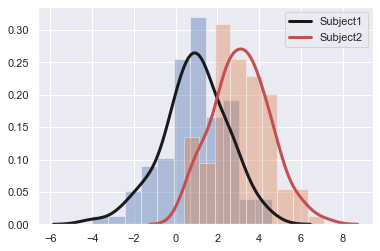

In [88]:
k = 16
t = 100
X = np.zeros((k,t),dtype=float)
Y = np.zeros(k,dtype=float)
cls = [8, 8]
sigma = [1.5, 1.5]
miu = [1, 3]

for i in range(0,k):
    if i < cls[0]:
        X[i,:] = np.random.normal(miu[0],sigma[0],t)
    else:
        X[i,:] = np.random.normal(miu[1],sigma[1],t)
        Y[i] = 1
        
sns.distplot(X[0,:], hist = True, kde_kws={"color": "k", "lw": 3, "label": "Subject1"})
sns.distplot(X[8,:], hist = True, kde_kws={"color": "r", "lw": 3, "label": "Subject2"})

#X = np.concatenate((sample1.reshape(1,-1),sample2.reshape(1,-1)),axis=0)
#Y = np.array([0,1])

In [89]:
p = p_value(X,Y)

In [90]:
p

9.999000099990002e-05